# Jialong Feng
# logistic regression, probit regression and linear regression


### Import libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn import linear_model


### Data processing
> this part is supposed to be modified and enrich by other partners

In [3]:
#dependent var: y
#independent var: ln(age) (continous)
#control vars: marital(categorical), education(categorical), balance(continuous), previous(continous), housing(binary)

bank_data = pd.read_csv('bank_data/bank.csv',sep=";")[['y','marital','education','balance','previous','housing','age']]
bank_data['y'] = bank_data['y'].map({'yes':1,'no':0})
bank_data['housing'] = bank_data['housing'].map({'yes':1,'no':0})
bank_data['marital'] = bank_data['marital'].map({'married':2,'single':1,'divorced':3})
bank_data['education'] = bank_data['education'].map({'tertiary':3,'secondary':2,'primary':1,'unknown':4})
# #print(bank_data.shape) 
# #bank_data.drop(bank_data[bank_data['education']=='unknown'].index, inplace=True)
# #print(bank_data.shape)
# #print(bank_data.shape)
# bank_data['education'].astype = 'int64'
# bank_data['marital'].astype = 'object'
# bank_data['y'].astype = 'object'
# bank_data['housing'].astype = 'object'

#bank_data = bank_data.astype({'education':'category','marital':'category','y':'category','housing':'category'})  
bank_data.dtypes

y            int64
marital      int64
education    int64
balance      int64
previous     int64
housing      int64
age          int64
dtype: object

### Model Construction

In [4]:
comparison_df = pd.DataFrame(index=['linear','probit','logit'])
#the comaprison dataframe is used to store the coefficients of the three models
#and other relevant indicators for further comparison

In [5]:
import statsmodels.formula.api as smf
#printo denotes whether to print the summary of regression or not
printo = True

#linear regression
linear_result = smf.ols('y ~ np.log(age) + C(marital) + C(education) + balance + previous + housing', data=bank_data).fit()
if printo: print("linear:",linear_result.summary())

#probit and logit regression
probit_result = smf.probit('y ~ np.log(age) + C(marital) + C(education) + balance + previous + housing', data=bank_data).fit()
if printo: print("probit:",probit_result.summary())
logit_result = smf.logit('y ~ np.log(age) + C(marital) + C(education) + balance + previous + housing', data=bank_data).fit()
if printo :print("logit:",logit_result.summary())

#saved the prediction result of each model based on the same data
linear_predict = linear_result.predict()
probit_predict = probit_result.predict()
logit_predict = logit_result.predict()

#save the indicators of models in final dataframe
comparison_df['AIC'] = [linear_result.aic,probit_result.aic,logit_result.aic]
comparison_df['BIC'] = [linear_result.bic,probit_result.bic,logit_result.bic]
comparison_df['(pseudo) R^2'] = [linear_result.rsquared,probit_result.prsquared,logit_result.prsquared]
comparison_df['llf'] = [linear_result.llf,probit_result.llf,logit_result.llf]
comparison_df['coefficient of age'] = [linear_result.params['np.log(age)'],probit_result.params['np.log(age)'],logit_result.params['np.log(age)']]
comparison_df['pvalue of age'] = [linear_result.pvalues['np.log(age)'],probit_result.pvalues['np.log(age)'],logit_result.pvalues['np.log(age)']]


linear:                             OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     16.40
Date:                Tue, 05 Dec 2023   Prob (F-statistic):           8.25e-27
Time:                        20:22:56   Log-Likelihood:                -1181.1
No. Observations:                4521   AIC:                             2382.
Df Residuals:                    4511   BIC:                             2446.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.0205  

### Return the machine learning result for comparison

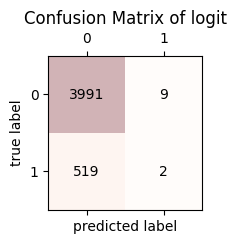

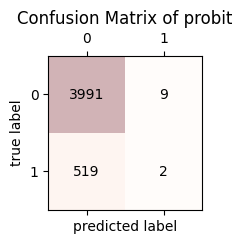

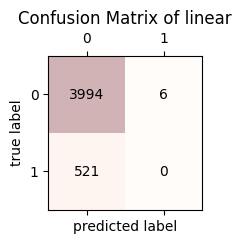

[[3991    9]
 [ 519    2]]


In [6]:
#calculate the accuracy of each model based on confusion matrix
from sklearn.linear_model import LogisticRegression #problem will be solved with scikit
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report, precision_score
import matplotlib.pyplot as plt

#whether_normalized denotes the type of confusion matrix
whether_normalized = None #'true','all','pred'

logit_confusion_matrix = confusion_matrix(y_true=bank_data['y'], y_pred=logit_predict>0.5,normalize=whether_normalized)
probit_confusion_matrix = confusion_matrix(y_true=bank_data['y'], y_pred=logit_predict>0.5,normalize=whether_normalized)
linear_confusion_matrix = confusion_matrix(y_true=bank_data['y'], y_pred=linear_predict>0.5,normalize=whether_normalized)

#saved the confusion matrix in final dataframe
comparison_df['confusion matrix'] = [linear_confusion_matrix,probit_confusion_matrix,logit_confusion_matrix]


#write a function to calculate the accuracy, specificity and sensitivity
def calculate_metrics(confusion_matrix):
    TP = confusion_matrix[1, 1]  # true positive
    TN = confusion_matrix[0, 0]  # true negatives
    FP = confusion_matrix[0, 1]  # false positives
    FN = confusion_matrix[1, 0]  # false negatives

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    specificity = TN / (TN + FP)
    sensitivity = TP / (TP + FN)

    return [round(accuracy,6),round(specificity,6),round(sensitivity,6)]

#save the value of accuray and specificity and sensitivity in dataframe
comparison_df[['accuracy','specificity','sensitivity']] = comparison_df['confusion matrix'].apply(calculate_metrics).apply(pd.Series)

#plot the confusion matrix
def plot_confusion_matrix(confusion_matrix,title):
    fig, ax = plt.subplots(figsize=(2, 2))
    ax.matshow(confusion_matrix, cmap=plt.cm.Reds, alpha=0.3)

    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            ax.text(x=j, y=i,
            s=confusion_matrix[i, j],
            va='center', ha='center')
    plt.xlabel('predicted label')
    plt.ylabel('true label')
    plt.title('Confusion Matrix of {}'.format(title))
    plt.show()

plot_confusion_matrix(logit_confusion_matrix,'logit')
plot_confusion_matrix(probit_confusion_matrix,'probit')
plot_confusion_matrix(linear_confusion_matrix,'linear')
print(probit_confusion_matrix)
#the following three charts are the confusion matrix (withou normalized)
#showing the confusion matrix of loan by age and other variables predicted
#by linear models, porbit models and logit models respectively

#due to the inherent statistical feature of our data,
#the portion of approved loan and rejected loan are imbalanced
#three models show similar pattern  of confusion matrix

In [7]:
regression_result = linear_result
hypotheses = ['np.log(age)']
waldstat = regression_result.wald_test(hypotheses)
teststat2_autom = waldstat.statistic[0][0]
pval2_autom = waldstat.pvalue
print(f'teststat2_autom: {teststat2_autom}\n')
print(f'pval2_autom: {pval2_autom}\n')

teststat2_autom: 4.21746187350095

pval2_autom: 0.04006748988374386



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:1906: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


### Return the likelihood ratio for comparison

In [19]:
#calculate the likelihood ratio test and wald test
import statsmodels.formula.api as smf
import scipy.stats as stats

def inference(regression_result,hypotheses = ['np.log(age)']): 


        
        # test of overall significance (test statistic and p-value):
        llr1_manual = 2 * (regression_result.llf - regression_result.llnull)
        print(f'llr1_manual: {llr1_manual}\n')
        print(f'results_probit.llr: {regression_result.llr}\n')
        print(f'results_probit.llr_pvalue: {regression_result.llr_pvalue}\n')

        # automatic Wald test of H0 (experience and age are irrelevant):
        
        waldstat = regression_result.wald_test(hypotheses)
        teststat2_autom = waldstat.statistic[0][0]
        pval2_autom = waldstat.pvalue
        print(f'teststat2_autom: {teststat2_autom}\n')
        print(f'pval2_autom: {pval2_autom}\n')

        # manual likelihood ratio statistic test
        # of H0 (experience and age are irrelevant):
        
        results_probit_restr = regression_result

        llr2_manual = 2 * (regression_result.llf - results_probit_restr.llf)
        pval2_manual = 1 - stats.chi2.cdf(llr2_manual, 3)
        print(f'llr2_manual2: {llr2_manual}\n')
        print(f'pval2_manual2: {pval2_manual}\n')

        return [regression_result.llr,regression_result.llr_pvalue,teststat2_autom,pval2_autom]

linear = [teststat2_autom,pval2_autom,None,None]
probit = inference(probit_result)
logit = inference(logit_result)

comparison_df[['llr','llr_pvalue','teststat2_autom','pval2_autom']] = [linear,probit,logit]

print(comparison_df[['llr','llr_pvalue','teststat2_autom','pval2_autom']])
#logit and probit models have higher likelihood ratio test than linear model
#and lower p-value, which means they are better models
#all three models have the likelihood ratio sigficant at the significant level of 5%

#both probit and logit models passed the wald test at the significant level of 5%
#which means the age and loan is relevant

llr1_manual: 130.84462580936088

results_probit.llr: 130.84462580936088

results_probit.llr_pvalue: 7.949543993817623e-24

teststat2_autom: 4.626891293374243

pval2_autom: 0.03147454308809057

llr2_manual2: 0.0

pval2_manual2: 1.0

llr1_manual: 127.40442284823212

results_probit.llr: 127.40442284823212

results_probit.llr_pvalue: 4.050554400983423e-23

teststat2_autom: 4.949233422384541

pval2_autom: 0.026102239851804286

llr2_manual2: 0.0

pval2_manual2: 1.0

               llr           llr_pvalue teststat2_autom           pval2_autom
linear    4.217462  0.04006748988374386             NaN                  None
probit  130.844626                  0.0        4.626891   0.03147454308809057
logit   127.404423                  0.0        4.949233  0.026102239851804286


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:1906: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


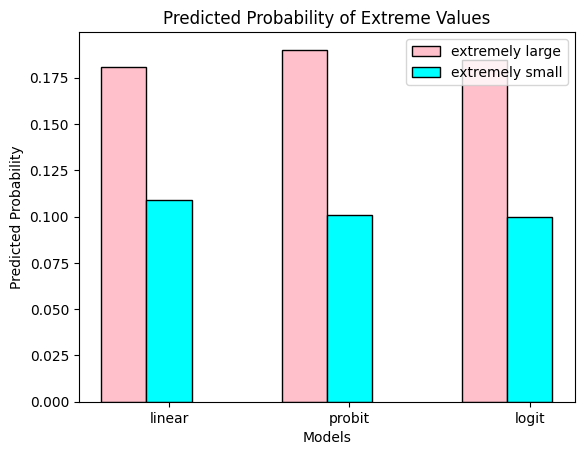

In [9]:
#testing the extreme cases
X_new = pd.DataFrame(
    {'marital': [3,1], 'education': [4, 1],
     'balance':[bank_data['balance'].max(),bank_data['balance'].min()], 'previous': [1, 0],
     'housing':[1,0], 'age':[bank_data['age'].max(),bank_data['age'].min()]})

#save the extrem cases in final dataframe     
comparison_df['extreme'] = [linear_result.predict(X_new),probit_result.predict(X_new),logit_result.predict(X_new)]

#plot the predicted probability of extreme cases
max_list =[]
min_list =[]


for i in range(3):
    max_list.append(comparison_df['extreme'][i][0])
    min_list.append(comparison_df['extreme'][i][1])

# Define the data
groups = comparison_df.index
max_list = max_list
min_list = min_list
comparison_df['extreme_max'] = max_list
comparison_df['extreme_min'] = min_list
# Set the width of the bars
bar_width = 0.25

# Set the positions of the bars on the x-axis
r1 = range(len(max_list))
r2 = [x + bar_width for x in r1]

# Create the bar plot
plt.bar(r1, max_list, color='pink', width=bar_width, edgecolor='black', label='extremely large')
plt.bar(r2, min_list, color='cyan', width=bar_width, edgecolor='black', label='extremely small')
#plt.bar(r3, bar3, color='blue', width=bar_width, edgecolor='black', label='Group 3')

# Add labels, title, and legend
plt.xlabel('Models')
plt.ylabel('Predicted Probability')
plt.title('Predicted Probability of Extreme Values')
plt.xticks([r + bar_width for r in range(len(max_list))], groups)
plt.legend()

# Show the plot
plt.show()
#The chart shows the predicted probability of extrem values
#based on three models respectively. The extremly large value and the extremely
#small values are selected as input to predict the probabiliy of a loan being approved
#it shows that the linear model shows a comparatively higher probability to be approved for 
#extremely large value whereas comparatively lower probabiliy for the extremely large value
#corresponding to the statistical assumption of the three models.

(1000, 6)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


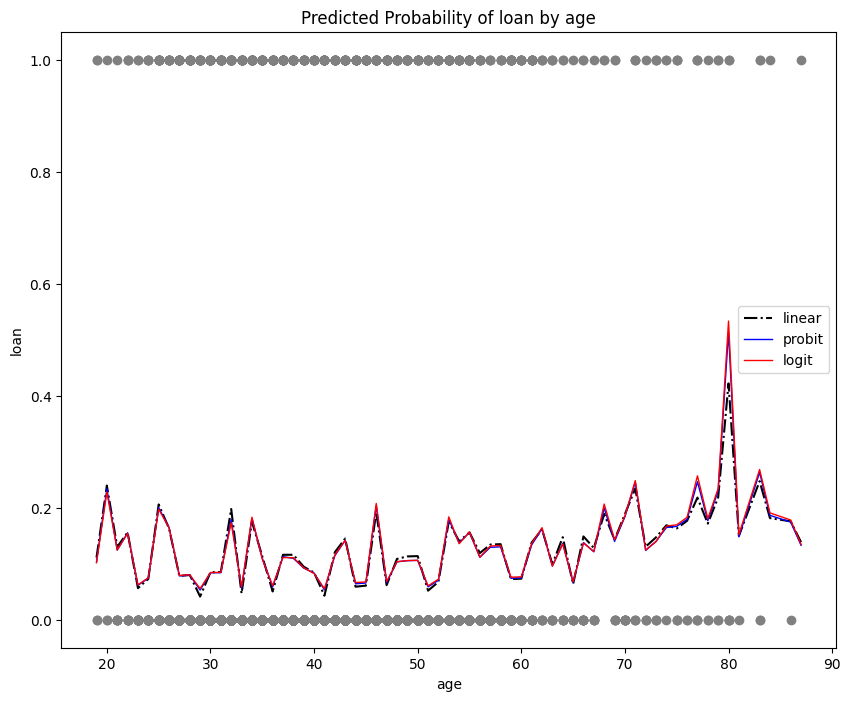

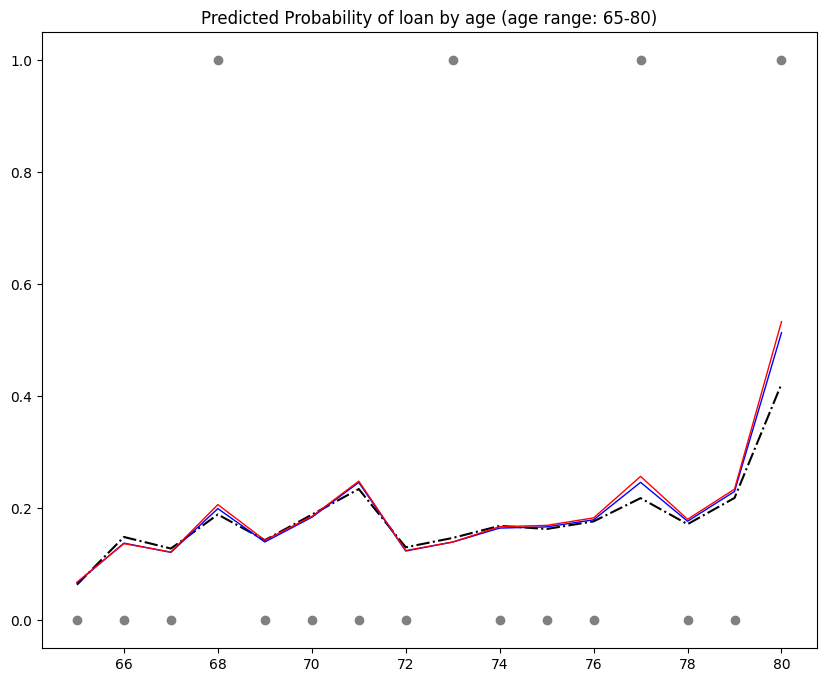

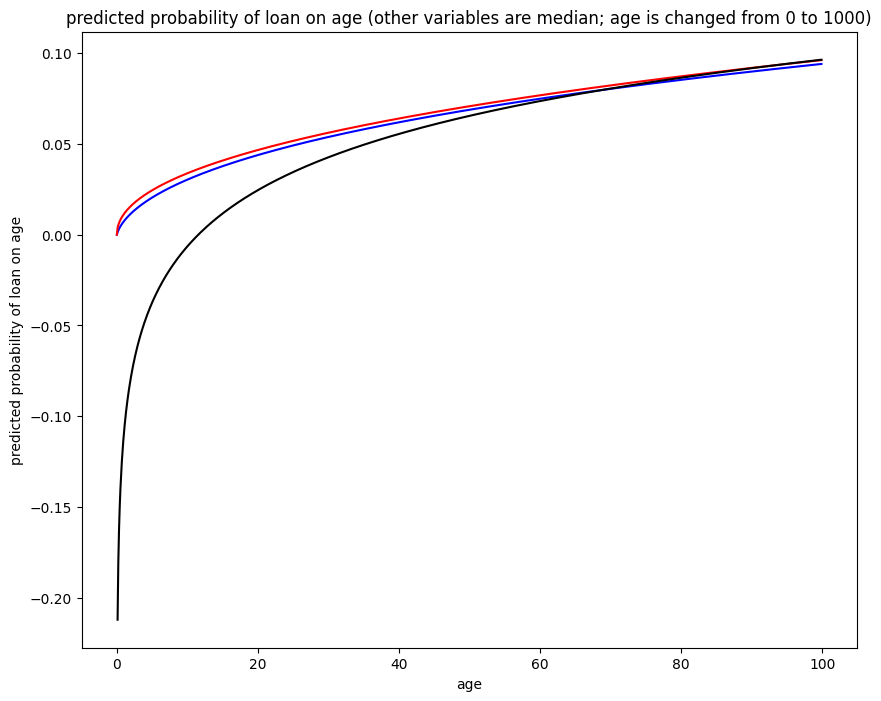

In [10]:
#calculate and plot the predicted probability of age
bank_data_sortedbyage = bank_data.copy().sort_values(by=['age'],ascending=True)
bank_data_sortedbyage.drop_duplicates(subset=['age'],keep='first',inplace=True)
bank_data_sortedbyage_original  = bank_data_sortedbyage.copy()
del bank_data_sortedbyage['y']
fig1, ax1 = plt.subplots(figsize=(10, 8))

plt.plot(bank_data['age'], bank_data['y'], color='grey', marker='o', linestyle='')
plt.plot(bank_data_sortedbyage['age'], linear_result.predict(bank_data_sortedbyage),
         color='black', linestyle='-.', label='linear')
plt.plot(bank_data_sortedbyage['age'], probit_result.predict(bank_data_sortedbyage),
         color='blue', linestyle='-', linewidth=1, label='probit')
plt.plot(bank_data_sortedbyage['age'], logit_result.predict(bank_data_sortedbyage),
        color='red', linestyle='-', linewidth=1, label='logit')
plt.ylabel('loan')
plt.xlabel('age')
plt.legend()
plt.title('Predicted Probability of loan by age')
# the chart is not very clear, so I plot the predicted probability of age in another way
#the chart shows that the predicted value of three models are very similar.
#considering that the real values of loan is not apparently seperated by age, the three models are all good
#according to the chart; and all three models cannot show a clear rising trend of loan by age


#A NEW PLOT
#------------------------------------------------------------------------------------
#plot the predicted probability of age in another way
#I select the age range between 65 and 80 to plot the predicted probability of age
fig2, ax2 = plt.subplots(figsize=(10, 8))
bank_data_sortedbyage_smallrange = bank_data_sortedbyage_original[(bank_data_sortedbyage_original['age']>=65) & (bank_data_sortedbyage_original['age']<=80)]
plt.plot(bank_data_sortedbyage_smallrange['age'], bank_data_sortedbyage_smallrange['y'], color='grey', marker='o', linestyle='')
plt.plot(bank_data_sortedbyage_smallrange['age'], linear_result.predict(bank_data_sortedbyage_smallrange),color = 'black', linestyle='-.', label='linear')
plt.plot(bank_data_sortedbyage_smallrange['age'], probit_result.predict(bank_data_sortedbyage_smallrange),color = 'blue', linestyle='-', linewidth=1, label='probit')
plt.plot(bank_data_sortedbyage_smallrange['age'], logit_result.predict(bank_data_sortedbyage_smallrange),color = 'red', linestyle='-', linewidth=1, label='logit')
plt.title('Predicted Probability of loan by age (age range: 65-80)')


#A SECOND NEW PLOT
#------------------------------------------------------------------------------------
#plot the predicted probability of age in another way
#setting other variables as median and unchanged, I plot the predicted probability of loan by age
#the chart shows that the predicted value of three models have similar trends
#the linear rises more quickly than the other two models from zero at the low value of age
#

fig3, ax3 = plt.subplots(figsize=(10, 8))
median_value = [2,2,444,0,1,0]
bank_data.columns
n = 1000
test_data = pd.DataFrame([median_value for i in range(n)],columns=['marital','education','balance','previous','housing','age'])
test_data['age'] = bank_data['age'].drop_duplicates().sort_values().dropna()
test_data['age'] = [i*0.1 for i in range(n)]
plt.plot(test_data['age'],probit_result.predict(test_data),color='blue')
plt.plot(test_data['age'],logit_result.predict(test_data),color='red')
plt.plot(test_data['age'],linear_result.predict(test_data),color='black')
plt.xlabel('age')
plt.ylabel('predicted probability of loan on age')
plt.title('predicted probability of loan on age (other variables are median; age is changed from 0 to 1000)')

print(test_data.shape)



Text(0.5, 1.0, 'Partial Effects of Age on Loan')

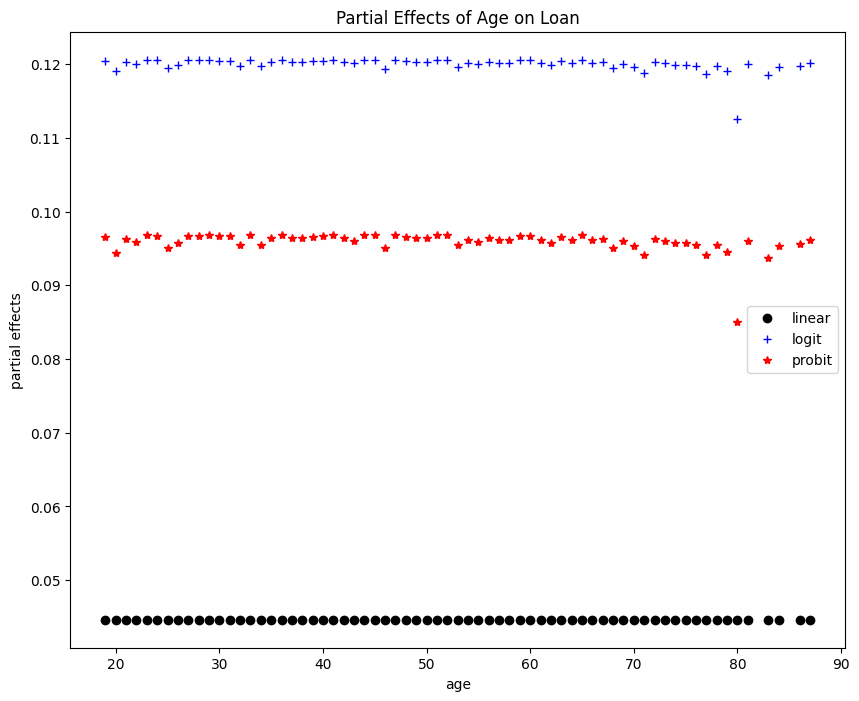

In [11]:
# calculate partial effects:
# using the back_data_sortedbyage dataframe

#line of linear regression partial effect
PE_lin = np.repeat(linear_result.params['np.log(age)'],bank_data_sortedbyage.shape[0])

#line of logit regression partial effect
xb_logit = logit_result.predict(bank_data_sortedbyage)
factor_logit = stats.logistic.pdf(xb_logit)
PE_logit = logit_result.params['np.log(age)'] * factor_logit

#line of probit regression partial effect
xb_probit = probit_result.predict(bank_data_sortedbyage)
factor_probit = stats.norm.pdf(xb_probit)
PE_probit = probit_result.params['np.log(age)'] * factor_probit




# plot APE's:
fig, ax = plt.subplots(figsize=(10, 8))
plt.plot(bank_data_sortedbyage['age'], PE_lin, color='black',
         marker='o', linestyle='', label='linear')
plt.plot(bank_data_sortedbyage['age'], PE_logit, color='blue',
         marker='+', linestyle='', label='logit')
plt.plot(bank_data_sortedbyage['age'], PE_probit, color='red',
         marker='*', linestyle='', label='probit')
plt.ylabel('partial effects')
plt.xlabel('age')
plt.legend()
plt.title('Partial Effects of Age on Loan')
#as shown in the chart: the partial effects of age on loan
#varies a lot in different models. The partial effect of age on loan
#remains constant and relatively low for linear model; while the 
#partial effect of age on loan is very high for logit and probit model and
#the variance of partial effect of age on loan is greater for logit and probit model

In [20]:
import numpy as np
from sklearn.utils import resample

#testing the robustness of coefficient of age using bootstrap
def bootstrap_regression(df,  num_iterations,funct,mean_age=0):
    coefficients = []
    
    for _ in range(num_iterations):
        # Resample the data with replacement
        resampled_df = resample(df, replace=True)
        
        # Fit the regression model
        model = funct('y ~ np.log(age) + C(marital) + C(education) + balance + previous + housing', data=resampled_df).fit()
        
        # Get the coefficient of x
        coefficient = model.params['np.log(age)']
        coefficients.append(coefficient)
    
    # Calculate the median, mean, and distribution of the coefficients
    median_coefficient = np.median(coefficients)
    mean_coefficient = np.mean(coefficients)
    coefficient_distribution = np.array(coefficients)
    # Plot the distribution of the coefficients 
    return [median_coefficient, mean_coefficient]#,coefficient_distribution

# Run the bootstrap function
n = 5
comparison_df[['bootstrap_median','bootstrap_mean']] = [bootstrap_regression(bank_data, n,smf.ols),bootstrap_regression(bank_data, n,smf.probit),bootstrap_regression(bank_data, n,smf.logit)]

#testing the robustness of coefficient of age using bootstrap
comparison_df[['bootstrap_median','bootstrap_mean','coefficient of age','pvalue of age']]


Optimization terminated successfully.
         Current function value: 0.324912
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.321418
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.317320
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.345606
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.341068
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.349039
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.340118
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.338768
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.352164
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.341286
  

,bootstrap_median,bootstrap_mean,coefficient of age,pvalue of age
linear,0.039676,0.033108,0.044634,0.040067
probit,0.145576,0.170974,0.243204,0.031475
logit,0.436547,0.424356,0.482835,0.026102


In [21]:
#marginal effect of logit regression
print(logit_result.get_margeff(at='mean').summary())
print(logit_result.get_margeff(at='mean').margeff)


        Logit Marginal Effects       
Dep. Variable:                      y
Method:                          dydx
At:                              mean
                       dy/dx    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
C(marital)[T.2]      -0.0398      0.011     -3.505      0.000      -0.062      -0.018
C(marital)[T.3]       0.0011      0.016      0.068      0.946      -0.030       0.032
C(education)[T.2]     0.0170      0.015      1.166      0.244      -0.012       0.046
C(education)[T.3]     0.0379      0.015      2.506      0.012       0.008       0.068
C(education)[T.4]    -0.0022      0.026     -0.083      0.933      -0.054       0.050
np.log(age)           0.0457      0.020      2.232      0.026       0.006       0.086
balance            5.944e-07   1.39e-06      0.429      0.668   -2.12e-06    3.31e-06
previous              0.0143      0.002      7.122      0.000       0.010 

In [22]:
print("dataframe of the indicators of three models:")
print("\n")
comparison_df.transpose()

dataframe of the indicators of three models:




,linear,probit,logit
AIC,2382.280121,3120.155612,3123.595815
BIC,2446.445006,3184.320497,3187.7607
(pseudo) R^2,0.031675,0.040497,0.039432
llf,-1181.140061,-1550.077806,-1551.797908
coefficient of age,0.044634,0.243204,0.482835
pvalue of age,0.040067,0.031475,0.026102
confusion matrix,"[[3994, 6], [521, 0]]","[[3991, 9], [519, 2]]","[[3991, 9], [519, 2]]"
accuracy,0.883433,0.883212,0.883212
specificity,0.9985,0.99775,0.99775
sensitivity,0.0,0.003839,0.003839


### Four prediction and reliability comparison

In [15]:
pivotal_bank_data = bank_data[bank_data.columns[1:]].apply(lambda x: [x.mean(),x.median(),x.std(),x.max(),x.min()])
pivotal_bank_data.index = ['mean','median','std','max','min']
pivotal_bank_data

,marital,education,balance,previous,housing,age
mean,1.852245,2.231365,1422.657819,0.542579,0.566025,41.170095
median,2.000000,2.000000,444.000000,0.000000,1.000000,39.000000
std,0.599650,0.748744,3009.638142,1.693562,0.495676,10.576211
max,3.000000,4.000000,71188.000000,25.000000,1.000000,87.000000
min,1.000000,1.000000,-3313.000000,0.000000,0.000000,19.000000


four prediction with different values only at age:
    marital  education  balance  previous  housing  age
0        2          2      444         0        1   19
1        2          2      444         0        1   29
2        2          2      444         0        1   39
3        2          2      444         0        1   49
linear_predict:
 0    0.022218
1    0.041092
2    0.054315
3    0.064504
dtype: float64
probit_predict:
 0    0.042680
1    0.052879
2    0.061113
3    0.068114
dtype: float64
logit_predict:
 0    0.045522
1    0.055263
2    0.063224
3    0.070074
dtype: float64
four prediction with different values at all variables
:         marital  education   balance  previous  housing  age
small         1          1  -3313.00         0        0   19
large         3          4  71188.00         1        1   87
median        2          2    444.00         0        1   39
random        3          3    200.86         0        1   52
linear_predict:
 small     0.108856
large     0.

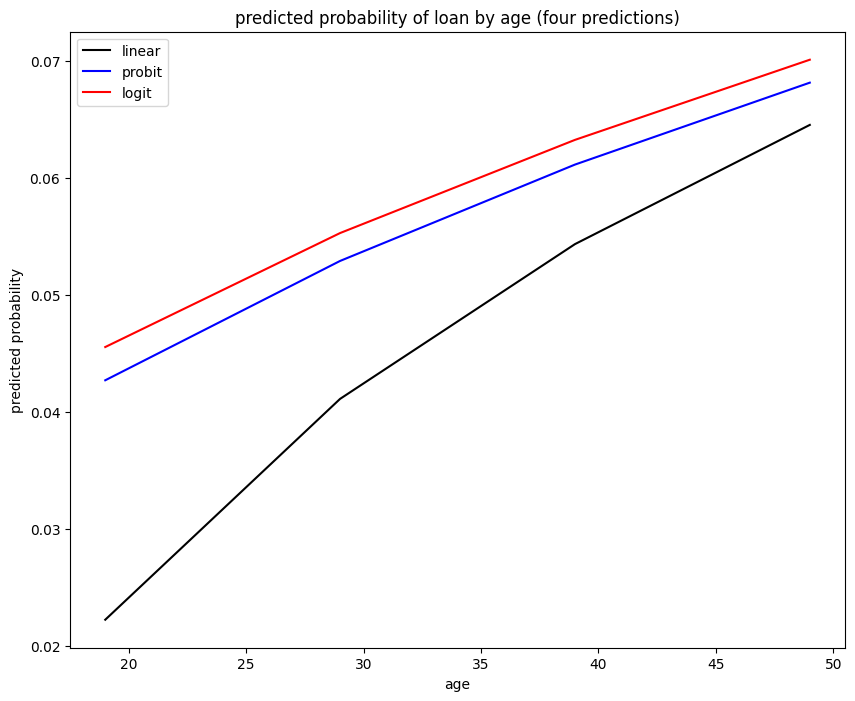

In [26]:
#create four prediction based on the pivotal_bank_data

#four prediction with different values only at age
values1 = [2,2,444,0,1,19]
values2 = [2,2,444,0,1,29]
values3 = [2,2,444,0,1,39]
values4 = [2,2,444,0,1,49]
four_prediction_df = pd.DataFrame([values1,values2,values3,values4],columns=['marital','education','balance','previous','housing','age'])
print("four prediction with different values only at age:\n",four_prediction_df)
print("linear_predict:\n",linear_result.predict(four_prediction_df))
print("probit_predict:\n",probit_result.predict(four_prediction_df))
print("logit_predict:\n",logit_result.predict(four_prediction_df))

fig, ax = plt.subplots(figsize=(10, 8))
plt.plot(four_prediction_df['age'], linear_result.predict(four_prediction_df), color='black',)
plt.plot(four_prediction_df['age'], probit_result.predict(four_prediction_df), color='blue',)
plt.plot(four_prediction_df['age'], logit_result.predict(four_prediction_df), color='red',)
plt.ylabel('predicted probability')
plt.xlabel('age')
plt.title('predicted probability of loan by age (four predictions)')
plt.legend(['linear','probit','logit'])
#the chart shows that the predicted probability of loan by age
#the predicted probability of loan increases as the age rises
#the 

#four prediction with different values at all variables
values1 = [1,1,-3313,0,0,19]
values2 = [3,4,71188,1,1,87]
values3 = [2,2,444,0,1,39]
values4 = [np.random.choice([1,2,3]),np.random.choice([1,2,3,4]),bank_data['balance'].quantile(round(np.random.random(),4)),np.random.choice([0,1]),np.random.choice([0,1]),np.random.choice(bank_data['age'])]
four_prediction_df = pd.DataFrame([values1,values2,values3,values4],columns=['marital','education','balance','previous','housing','age'],index= ['small','large','median','random'])
print("four prediction with different values at all variables\n:",four_prediction_df)
print("linear_predict:\n",linear_result.predict(four_prediction_df))
print("probit_predict:\n",probit_result.predict(four_prediction_df))
print("logit_predict:\n",logit_result.predict(four_prediction_df))

#it shows that the predicted probability of logit and probit model are very similar
#linear models seems to be less acurate at the extrame values of age

#all models are reliable based on their prediction results
#yet the logit and probit model are more reliable than linear model
#since they have better performance at the extreme values of age

In [17]:
[i for i in range(-3,3)]

[-3, -2, -1, 0, 1, 2]

# Conclusion

In [18]:
#I choose the logit model as the best model
#since it has the highest (pseudo) R^2 and the lowest AIC and BIC
#also the p-value of age is the lowest among three models
#and the predicted probability of age is the most reasonable among three models

#according to logistic regression, the coefficient of age is 0.48
#the marginal effect of logit regression is 0.48 * factor_logit
#which is 0.0457,which means that the probability of loan increases by 0.0457
#when age increases by 1% cataris paribus